# Neural Networks in Action for Time Series Forecasting : Only Code

### Objective: Understand and implement CNNs and LSTMs by forecasting the Nifty500 returns
### Data Source : CEIC

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 36kB/s 
     |████████████████████████████████| 3.8MB 47.0MB/s 
     |████████████████████████████████| 512kB 43.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f85203b29b1fa3effb2b3b7420268ecdb36bcaf04a5db5c4ca7c0d73cb0c9879
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

# Importing Basic Libraries 

In [ ]:
#make sure you have the correct versions installed
import keras
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.3.1


In [ ]:
#check version of tensorflow
import random as rn

import numpy as np
import pandas as pd
import os
import glob
import datetime
import pandas as pd

# 1. Load the data

In [ ]:
#google collab method - 2
from google.colab import drive
drive.mount('/content/drive')

PATH ="drive/'My Drive'/cfa_webinar"
df = pd.read_csv('drive/My Drive/cfa_webinar/cfa_nn_data.csv') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#################### Uncomment these (remove the #) if running on own machine#########################
#changing the directory to where you have downloaded the data
#os.chdir('C:\\Users\\Cafral\\Desktop\\CAFRAL\\Intro MLTS\\cfa_data')

#df = pd.read_csv('cfa_nn_data.csv')
######################################################################################################

df.drop(['Unnamed: 0'],inplace=True,axis=1) #removing unnecessary columns

#reformatting and sorting by date
df['date'] = pd.to_datetime(df['date']) #always format the date
df = df.sort_values(['date'])

# 2. Cleaning the Data

### 2.1 Next, it is important to drop weekends as the Indian stock market does not normally trade on weekends.

In [ ]:
#Removing weekends
df = df[(df['date'].dt.dayofweek != 5)&(df['date'].dt.dayofweek != 6)]

### 2.2 Now, dealing with missing values: first , all the columns with more that 10% of missing values are dropped.

In [ ]:
#dropping if ptage of missing values is greater than 10%
df = df.loc[:, df.isna().sum()/df.shape[0] <= 0.1]
df = df.dropna(axis=0,how='all',subset=df.columns[1:])

### 2.3 Second, for the remaining columns with at most 10% missing observation, the missing values are fillied using linear interpolation. 

In [ ]:
#linear interpolation to deal with missing data
date = df['date']
df = df[df.columns[1:]].astype(float).interpolate(method ='linear',axis = 0,limit=30,
                                                              limit_direction ='forward')

#sort by date
df['date'] = date
df = df.sort_values(['date'])

# 3. Making the Data Stationary

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


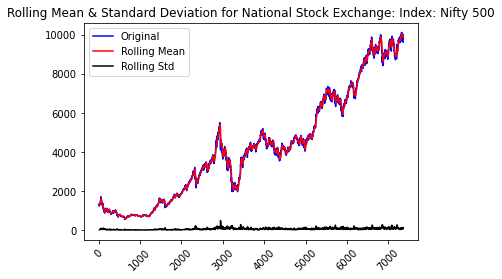

Results of Dickey-Fuller Test:
Test Statistic                    0.078353
p-value                           0.964552
# Lags Used                      13.000000
Number of Observations Used    5244.000000
Critical Value (1%)              -3.431598
Critical Value (5%)              -2.862091
Critical Value (10%)             -2.567063
dtype: float64


In [ ]:
# Defining a function to test stationarity
#SOURCE:https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.x13
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots

def test_stationarity(df, ts):

    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts], color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()

    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = statsmodels.tsa.stattools.adfuller(df[ts], autolag='AIC') #add kpss
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value', '# Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#Applying the function to our Y variable: National Stock Exchange: Index: Nifty 500
test_stationarity(df, 'National Stock Exchange: Index: Nifty 500')

In [ ]:
#Defining a function to calculate percentage change
def percentChange(x,numLags):
    '''
    INPUTS:
    x: Column for which we want to calculate percent change
    numLags: The number of days from when the change needs to be calculated. 
            Example : If using daily data - numLags = 1 for daily change
                                            numLags = 30 for monthly change
                                            numLags = 365 for yearly change       
    OUTPUT:
    percentage change in variable
    '''
    y = (x - x.shift(numLags))/x.shift(numLags)
    return y

dataForMl = pd.DataFrame()
dataForMl['date'] = df['date']

#here, I only have level variables so I do not need separate my variables into level vs non-level variables
levelVars = df.columns[:-1]
for levelVar in levelVars:
    dataForMl[f'{levelVar}Ret'] = percentChange(df[levelVar],1)
    
dataForMl = dataForMl[1:] #ignoring the first row as it contains null values

Having calculated the percentage change for all our variables, let's check if our data is stationary now

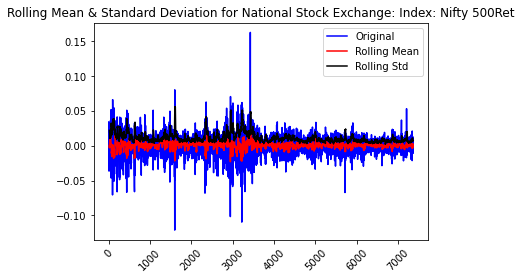

Results of Dickey-Fuller Test:
Test Statistic                -1.741829e+01
p-value                        4.842084e-30
# Lags Used                    1.300000e+01
Number of Observations Used    5.243000e+03
Critical Value (1%)           -3.431598e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567064e+00
dtype: float64


In [ ]:
test_stationarity(dataForMl, 'National Stock Exchange: Index: Nifty 500Ret')

- From the above graphs, we see that the percentage change in Nifty 500 Index (i.e. National Stock Exchange: Index: Nifty 500Ret) is stationary as the p-value is less that 0.05. 
- Again, for greater intuition look at the graph - the rolling mean and rolling standard deviation lines are along are almost flat meaning that they don't change in a statistically significant manner over time.
- However, do note that taking the first difference does not necessarily have to make the data stationary.

# 4. Lagging the Data

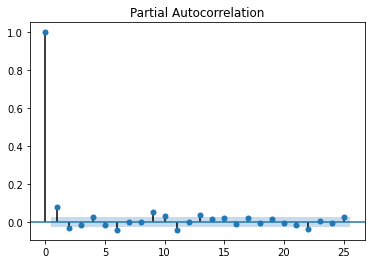

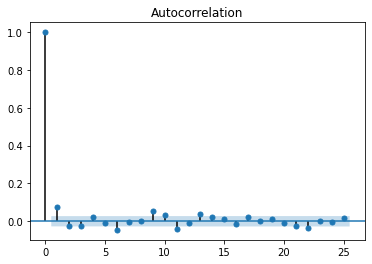

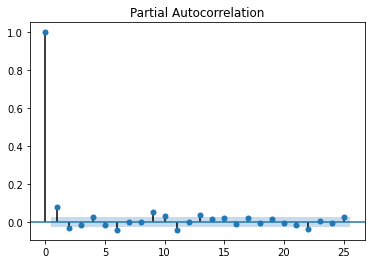

In [ ]:
# We can make the acf and pacf plots using the statsmodels library in Python
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf

tsaplots.plot_acf(dataForMl['National Stock Exchange: Index: Nifty 50Ret'].astype(float),lags =25)
tsaplots.plot_pacf(dataForMl['National Stock Exchange: Index: Nifty 50Ret'].astype(float),lags =25)

- Both the ACF and PACF plots show high serial correlation at the first lag. 

In [ ]:
# Since we're going to forecast the one day ahead Nifty stock returns, the minimum lag considered by me is 1
minLagNum = 1

#lagging the vars :here i'm iginoring the ACF and PACF lag structure and deciding the maximum number of lags heuristically
maxLagNum = 10 #here I have chosen the maxLagNum arbitrarily. A better strategy is to look at the acf plot
dataForMl = dataForMl.sort_values(['date'])
for column in dataForMl.columns:
    for lag in range(minLagNum,maxLagNum+1):
        dataForMl[f'{column}Lag_{lag}'] = dataForMl[f'{column}'].shift(lag)
        

dataForMl.head(5)

,date,Bombay Stock Exchange: Index: 100Ret,Bombay Stock Exchange: Index: SENSEXRet,Bombay Stock Exchange: Index: 200Ret,Bombay Stock Exchange: Index: Dollex-200Ret,Bombay Stock Exchange: Index: 500Ret,Bombay Stock Exchange: Index: Information TechnologyRet,Bombay Stock Exchange: Index: Capital GoodsRet,Bombay Stock Exchange: Index: Fast Moving Consumer GoodsRet,Bombay Stock Exchange: Index: Consumer DurablesRet,Bombay Stock Exchange: Index: Health CareRet,Bombay Stock Exchange: Index: AutoRet,Bombay Stock Exchange: Index: MetalRet,Bombay Stock Exchange: Index: Oil & GasRet,Bombay Stock Exchange: PE Ratio: Index: SENSEXRet,Bombay Stock Exchange: PE Ratio: Index: 100Ret,Bombay Stock Exchange: PE Ratio: Index: 200Ret,Bombay Stock Exchange: PB Ratio: Index: SENSEXRet,Bombay Stock Exchange: PB Ratio: Index: 100Ret,Bombay Stock Exchange: PB Ratio: Index: 200Ret,Bombay Stock Exchange: Dividend Yield: Index: SENSEXRet,Bombay Stock Exchange: Dividend Yield: Index: 100Ret,Bombay Stock Exchange: Dividend Yield: Index: 200Ret,Bombay Stock Exchange: Scrips: Trade: TotalRet,Bombay Stock Exchange: Scrips: Trade: AdvanceRet,Bombay Stock Exchange: Scrips: Trade: DeclineRet,Bombay Stock Exchange: Scrips: Trade: UnchangedRet,Bombay Market Commodity Price: Gold: StandardRet,Bombay Market Commodity Price: Silver: .999Ret,RBI: Companies: Commercial Paper: Effective Discount Rate: LowRet,RBI: Companies: Commercial Paper: Effective Discount Rate: HighRet,Deposit Rate: RBI: 5 Major Banks: Maturity > 1 Year: LowRet,Deposit Rate: RBI: 5 Major Banks: Maturity > 1 Year: HighRet,Foreign Exchange Rates: RBI: Interbank Forward Premia of USD: 1 MthRet,Foreign Exchange Rates: RBI: Interbank Forward Premia of USD: 3 MthsRet,RBI: Bank RateRet,Lending Rate: SBI: Benchmark Prime Lending Rate (BPLR)Ret,SCB: Certificates of Deposits: Effective Interest Rate: LowRet,SCB: Certificates of Deposits: Effective Interest Rate: HighRet,Wholesale Debt Market: NSE: Securities: Trade: NumberRet,...,National Stock Exchange: Turnover: Trade: AdvanceRetLag_1,National Stock Exchange: Turnover: Trade: AdvanceRetLag_2,National Stock Exchange: Turnover: Trade: AdvanceRetLag_3,National Stock Exchange: Turnover: Trade: AdvanceRetLag_4,National Stock Exchange: Turnover: Trade: AdvanceRetLag_5,National Stock Exchange: Turnover: Trade: AdvanceRetLag_6,National Stock Exchange: Turnover: Trade: AdvanceRetLag_7,National Stock Exchange: Turnover: Trade: AdvanceRetLag_8,National Stock Exchange: Turnover: Trade: AdvanceRetLag_9,National Stock Exchange: Turnover: Trade: AdvanceRetLag_10,National Stock Exchange: Turnover: Trade: DeclineRetLag_1,National Stock Exchange: Turnover: Trade: DeclineRetLag_2,National Stock Exchange: Turnover: Trade: DeclineRetLag_3,National Stock Exchange: Turnover: Trade: DeclineRetLag_4,National Stock Exchange: Turnover: Trade: DeclineRetLag_5,National Stock Exchange: Turnover: Trade: DeclineRetLag_6,National Stock Exchange: Turnover: Trade: DeclineRetLag_7,National Stock Exchange: Turnover: Trade: DeclineRetLag_8,National Stock Exchange: Turnover: Trade: DeclineRetLag_9,National Stock Exchange: Turnover: Trade: DeclineRetLag_10,National Stock Exchange: TradeRetLag_1,National Stock Exchange: TradeRetLag_2,National Stock Exchange: TradeRetLag_3,National Stock Exchange: TradeRetLag_4,National Stock Exchange: TradeRetLag_5,National Stock Exchange: TradeRetLag_6,National Stock Exchange: TradeRetLag_7,National Stock Exchange: TradeRetLag_8,National Stock Exchange: TradeRetLag_9,National Stock Exchange: TradeRetLag_10,National Stock Exchange: Market Capitalization: TotalRetLag_1,National Stock Exchange: Market Capitalization: TotalRetLag_2,National Stock Exchange: Market Capitalization: TotalRetLag_3,National Stock Exchange: Market Capitalization: TotalRetLag_4,National Stock Exchange: Market Capitalization: TotalRetLag_5,National Stock Exchange: Market Capitalization: TotalRetLag_6,National Stock Exchange: Market Capitalization: TotalRetLag_7,National Stock Exchange: Marke

In [ ]:
#sort by date
dataForMl = dataForMl.sort_values(['date'])

#removing columns if nan value in a column
dataForMl = dataForMl.dropna()

#specifying independent variables:including only lagged versions of variables and excluding date variables
final_vars = [col for col in dataForMl.columns if (col.find('Lag')!=-1) & (col.find('date')==-1)]

#specifying the dependent variable
dep_var = 'National Stock Exchange: Index: Nifty 500Ret'

#always make the dependent ariable the last column in the dataset
final_vars.append(dep_var)

#for later use
dataForMl_copy = dataForMl

#keeping only relevant 
dataForMl = dataForMl[final_vars]

# 5. Breaking the data into train and test along time dim

In [ ]:

test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(dataForMl)))
training = dataForMl[:-no_test_obs]
testing = dataForMl[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.70
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

# 6. Rescaling Normalized Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
trainMinmax = min_max_scaler.fit_transform(training.values) #fit and transform training data
valMinmax = min_max_scaler.transform(validation.values)
outSampleMinmax = min_max_scaler.transform(outOfSample.values)

In [ ]:
#breaking the data into independent variables (x) and dependent variables (y)

#training independent, dependent
trainMinmax_x,trainMinmax_y = trainMinmax[:,:-1],trainMinmax[:,-1] 

#validation independent, dependent
valMinmax_x,valMinmax_y = valMinmax[:,:-1],valMinmax[:,-1]

#out of sample testing independent, dependent
outSampleMinmax_x,outSampleMinmax_y = outSampleMinmax[:,:-1],outSampleMinmax[:,-1]

# 7.  Metric to be used to guage accuracy of forecasts
- The most commonly used metric for guaging the accuracy of time series forecasts is the Mean Squared Error (MSE)
- The higher the MSE, the worse is the predictive accuracy of the model.
- Thus for each model,it is desired that the MSE be minimized. 

In [ ]:
from sklearn.metrics import mean_squared_error

# 8. Time Series Forecasting

# SARIMA

In [ ]:
#DEFINING SARIMA MODEL
import statsmodels.tsa.stattools
import statsmodels.api as sm

#(p,d,q) are determined using  Autocorrelation Function (ACF) , Partial Autocorrelation Functions (PACF) and tests for stationary.  
#How do we interpret ACF and PACF plots?

#p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
#q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

p= 1 #the trend autoregressive order.
d= 0 #the trend difference order.
q= 1 #the trend moving average order

P= 1 #the number of seasonal autoregressive terms.
D= 0 #the number of seasonal difference terms
Q= 1 #the number of seasonal moving average terms
M=1 #the number of time steps for a seasonal period 

myorder = (p,d,q)
myseasonalorder = (P,D,Q,M)
model = sm.tsa.statespace.SARIMAX(trainMinmax_y,
                                  order=myorder, 
                                  seasonal_order=myseasonalorder,
                                  trend='c')#,exog=trainMinmax_x 

#Training the model
model_fit = model.fit() 

# In case you want to add exgogenous variables
#exogNormal = normalizer.transform(testing.values)
#exogMinmax = min_max_scaler.transform(exogNormal)
#exogMinmax_x,exogMinmax_y = exogMinmax[:,:-1],exogMinmax[:,-1]

#Predicting
totat_preds = len(testing)#len(exogMinmax_y)
sarimaPred = model_fit.predict(start=1, end=totat_preds)#exog=exogMinmax_x

In [ ]:
def plot_results(actual_y,predicted_y,method,date):
    mse = mean_squared_error(actual_y,predicted_y)
    
    plt.figure(figsize=(16,4))
    plt.plot(date,actual_y)
    plt.plot(date,predicted_y)
    plt.legend(['Actual','Predicted'])
    plt.title(f'{method} (MSE: {mse})')        
    plt.show()

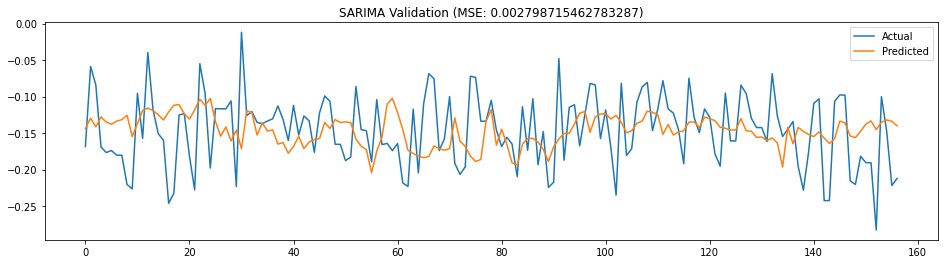

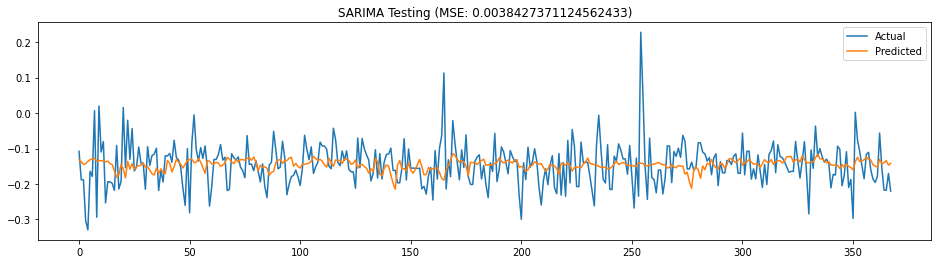

In [ ]:
plot_results(valMinmax_y,sarimaPred[:len(valMinmax_y)],'SARIMA Validation',range(len(valMinmax_y)))
plot_results(outSampleMinmax_y,sarimaPred[len(valMinmax_y):],'SARIMA Testing',range(len(outSampleMinmax_y)))

![](sarima_vs_ols.PNG==100x20)

# Neural Networks

In [ ]:
from numpy import array

#split a multivariate sequence into samples that preserve the temporal structure of the data
#SOURCE:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
n_steps_in =30 #number of observations from the past that we assume to be relevant across time for forecasting
n_steps_out = 1 #number of units ahead that we want to forecast into the future

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

In [ ]:
trainMinmax.shape #Output: (rows,columns)

(4722, 601)

In [ ]:
trainSeq_x.shape #Output: (number of samples,size of 'window' /timesteps,number of independent variables)

(4693, 30, 600)

### Important

- The intitial weights of a neural network at assigned randomly and greatly affect how the network performs. 
- If you run your neural network - with the exactly same code and hyper-parameters - repeately, you will get different results
 - Solution: Fix the random weights to the same weights every time the neural network is run

# Convolutional Neural Network

In [ ]:
# Implementing a neural network in Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling1D,MaxPooling1D
from keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1,l2,l1_l2

In [ ]:
############################# For Replicability : Always run this as one cell ##########################################
#SOURCE :
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_random_seed(1234)
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################

#While training the neural network, it is important that we use the MSE error of the validation set to decide when to 
#stop training our network. If we use the MSE of the training set, we will not get good predictions in the test set due 
#to over fitting. However, unlike the error in the training set, the error in the validation set does not reduce with 
#every passing epoch. Sometimes, it increases for a while before it starts declining. The patience argument in Earlystop allows us 
#to decide how many times we want the validation error to keep increasing before we stop training the neural network.

EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)

epochs = 100000 #number of times the feed forward mechanism and back propagation are repeated 

bs = 100 #batch size for SGD :show what happens when batch size very small
lr =0 #learning rate: the degree to which the weights are updated by each batch of SGD

sgd = SGD(lr=lr) #type of optimizer - Alternative: ADAM, NADAM

X, y = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X.shape[2]

np.random.seed(0)

model = Sequential() #initializing keras Sequential model

#convolutional layer starts
model.add(Conv1D(filters=5,#number of filters
                 kernel_size=2,#size of the filte racross time
                 strides=2, #number of rows that the filter moves ahead by
                 activation='linear',#transformation
                 input_shape=(n_steps_in, n_features))) #shape of 1 sample : preserves temporal structure
                #kernel_regularizer=l2(0.009),, bias_regularizer=l2(0.01)
#convolutional layer ends

model.add(MaxPooling1D(pool_size=1)) #sub-sampling layer - Alternative: AveragePooling1D

#model.add(BatchNormalization())
model.add(Dropout(0.1)) #reduces overfitting by dropping some weights randomly

#regression layer begins
model.add(Flatten())
model.add(Dense(1,#number of outputs
                activation='tanh',#transformation:other options include - ReLU,Linear,Sigmoid
                kernel_regularizer=l2(0.01))) 

model.compile(loss='mean_squared_error', optimizer='sgd') #specifies which optimizer and loss funtion to useto use 

#training the model
model.fit(trainSeq_x, trainSeq_y,
          batch_size=bs,
          epochs=epochs, 
          callbacks= [EarlyStop] ,
          verbose=2, 
          shuffle=False,#always set to false for time series data
          validation_data =(validationSeq_x, validationSeq_y))
                         
    
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 4693 samples, validate on 128 samples
Epoch 1/100000
 - 1s - loss: 0.1225 - val_loss: 0.0313
Epoch 2/100000
 - 1s - loss: 0.0532 - val_loss: 0.0297
Epoch 3/100000
 - 1s - loss: 0.0473 - val_loss: 0.0278
Epoch 4/100000
 - 1s - loss: 0.0439 - val_loss: 0.0242
Epoch 5/100000
 - 1s - loss: 0.0407 - val_loss: 0.0250
Epoch 6/100000
 - 1s - loss: 0.0388 - val_loss: 0.0222
Epoch 7/100000
 - 1s - loss: 0.0361 - val_loss: 0.0212
Epoch 8/100000
 - 1s - loss: 0.0349 - val_loss: 0.0208
Epoch 9/100000
 - 1s - loss: 0.0335 - val_loss: 0.0200
Epoch 10/100000
 - 1s - loss: 0.0328 - val_loss: 0.0192
Epoch 11/100000
 - 1s - loss: 0.0314 - val_loss: 0.0187
Epoch 12/100000
 - 1s - loss: 0.0306 - val_loss: 0.0183
Epoch 13/100000
 - 1s - loss: 0.0298 - val_loss: 0.0175
Epoch 14/100000
 - 1s - loss: 0.0290 - val_loss: 0.0171
Epoch 15/100000
 - 1s - loss: 0.0281 - val_loss: 0.0166
Epoch 16/100000
 - 1s - loss: 0.0277 - 

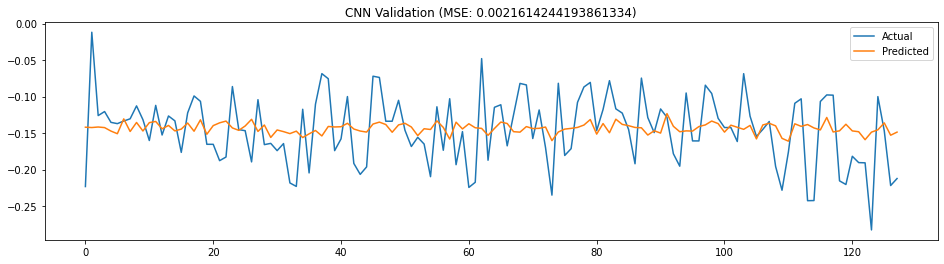

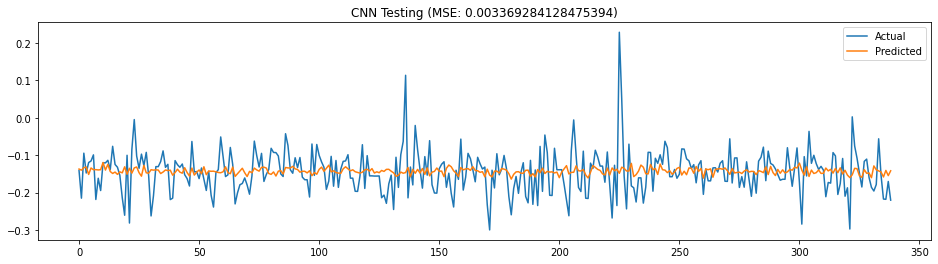

In [ ]:
# validation metrics 
cnnValPred = model.predict(validationSeq_x)

#testing prediction
cnnOutSamplePred = model.predict(outSampleSeq_x)
    
plot_results(validationSeq_y ,cnnValPred  ,'CNN Validation',range(len(validationSeq_y)))
plot_results(outSampleSeq_y ,cnnOutSamplePred  ,'CNN Testing',range(len(outSampleSeq_y)))

# Long Short Term Memory Network (LSTM)

In [ ]:
#best
from keras.layers import LSTM

################################### Set for replicability ##################################################################
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_random_seed(1234)
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################


EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)
epochs = 100000
lr =0

sgd = SGD(lr=lr) #; adam = Adam(lr=lr) ;nadam = Nadam(lr=lr)
bs = 100

n_steps_in =30
n_steps_out = 1

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

X_useless, y_useless = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X_useless.shape[2]

np.random.seed(0); print(np.random.rand(4))

model = Sequential()
model.add(LSTM(300, #number of LSTM nodes
               input_shape=(n_steps_in, n_features),
               activation = 'tanh')) #ransformation:best to not use any other type of transformation
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

#model
model.fit(trainSeq_x, trainSeq_y,batch_size=bs,epochs=epochs, callbacks= [EarlyStop] ,verbose=2, shuffle=False,
                         validation_data =(validationSeq_x, validationSeq_y))

[0.5488135  0.71518937 0.60276338 0.54488318]
Train on 4693 samples, validate on 128 samples
Epoch 1/100000
 - 20s - loss: 0.3244 - val_loss: 0.0025
Epoch 2/100000
 - 20s - loss: 0.0280 - val_loss: 0.0027
Epoch 3/100000
 - 22s - loss: 0.0254 - val_loss: 0.0027
Epoch 4/100000
 - 23s - loss: 0.0240 - val_loss: 0.0028
Epoch 5/100000
 - 23s - loss: 0.0235 - val_loss: 0.0027
Epoch 6/100000
 - 22s - loss: 0.0225 - val_loss: 0.0025
Epoch 7/100000
 - 22s - loss: 0.0223 - val_loss: 0.0026
Epoch 8/100000
 - 23s - loss: 0.0214 - val_loss: 0.0030
Epoch 9/100000
 - 22s - loss: 0.0203 - val_loss: 0.0026
Epoch 10/100000
 - 23s - loss: 0.0199 - val_loss: 0.0027
Epoch 11/100000
 - 21s - loss: 0.0192 - val_loss: 0.0024
Epoch 12/100000
 - 21s - loss: 0.0180 - val_loss: 0.0028
Epoch 13/100000
 - 21s - loss: 0.0182 - val_loss: 0.0024
Epoch 14/100000
 - 21s - loss: 0.0169 - val_loss: 0.0026
Epoch 15/100000
 - 21s - loss: 0.0169 - val_loss: 0.0024
Epoch 16/100000
 - 21s - loss: 0.0167 - val_loss: 0.0029
Epoc

Epoch 143/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 144/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 145/100000
 - 21s - loss: 0.0099 - val_loss: 0.0022
Epoch 146/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 147/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 148/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 149/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 150/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 151/100000
 - 21s - loss: 0.0098 - val_loss: 0.0022
Epoch 152/100000
 - 20s - loss: 0.0099 - val_loss: 0.0022
Epoch 153/100000
 - 20s - loss: 0.0099 - val_loss: 0.0022
Epoch 154/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 155/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 156/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300)               1081200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 1,081,501
Trainable params: 1,081,501
Non-trainable params: 0
_________________________________________________________________


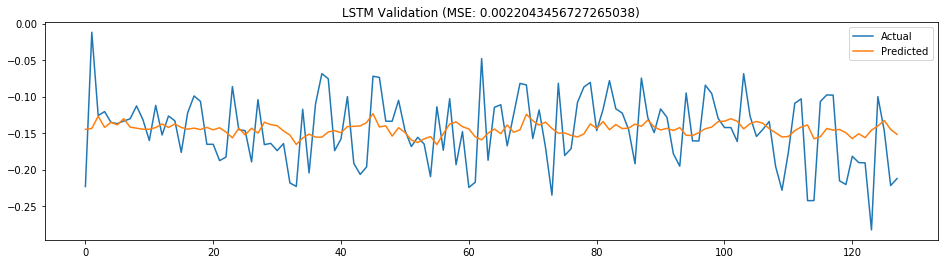

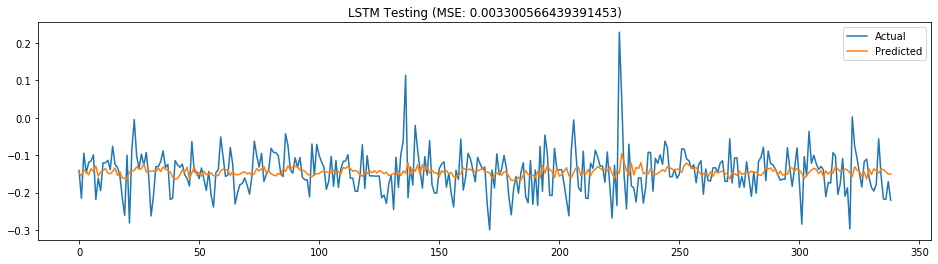

In [ ]:
# validation metrics 
lstmValPred = model.predict(validationSeq_x)
#out of sample metrics
lstmOutSamplePred = model.predict(outSampleSeq_x)

plot_results(validationSeq_y ,lstmValPred  ,'LSTM Validation',range(len(validationSeq_y )))
plot_results(outSampleSeq_y ,lstmOutSamplePred  ,'LSTM Testing',range(len(outSampleSeq_y)))

# 9. Saving a Neural Network Model to use it later

In [ ]:
######################## uncomment if running on own machine and not Colaboratory #########################
# Create directory for storing output
#dirName = f'C:\\Users\\Cafral\\Desktop\\CAFRAL\\Intro MLTS\\output' #change name to suitable folder here

#try:
#    # Create target Directory
#    os.mkdir(dirName)
#    print("Directory " , dirName ,  " Created ") 
#except FileExistsError:
#    print("Directory " , dirName ,  " already exists")

#change directory
#os.chdir(dirName)

#############################################################################################################
#specify model name
model_name='cnn'
filename = f'{model_name}_model.h5'
model.save(filename)

# 10. Calling a Saved Model

In [ ]:
import keras

#change directory
model_name='cnn' #change name of your model here
filename = f'{model_name}_model.h5' 
saved_model = keras.models.load_model(filename)


yhat = saved_model.predict(outSampleSeq_x) 
mse = mean_squared_error(outSampleSeq_y,cnnOutSamplePred)
print(mse)

0.003369284128475394


# 11 Invert the Scaling

In [ ]:
from numpy import concatenate
def invert_scaling(x_minmax,y_predicted,n_steps_in):
    reshaped_pred = y_predicted.reshape((y_predicted.shape[0],1))
    matrix = concatenate((x_minmax[n_steps_in-1:],reshaped_pred), axis=1)
    matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
    inv_pred = matrix_min_max_invert[:,-1]
    return inv_pred

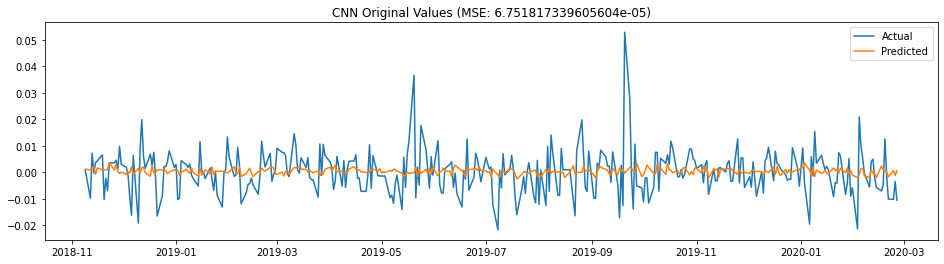

In [ ]:
inv_yhat = invert_scaling(outSampleMinmax_x,cnnOutSamplePred,n_steps_in)
plot_results(dataForMl_copy['National Stock Exchange: Index: Nifty 500Ret'][-(no_validation_obs-n_steps_in+1):].values,
             inv_yhat,
             'CNN Original Values',
             dataForMl_copy['date'][-(no_validation_obs-n_steps_in+1):])